<a href="https://colab.research.google.com/github/amarabuco/am-pos-2020-2/blob/main/Quest%C3%A3o_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Questão 2 - Enunciado

Considere novamente os dados "banknote authentication Data Set".
* a) Use **validação cruzada estratificada “10-folds”** para avaliar e comparar os classificadores combinados descritos abaixo. Quando necessario, retire do conjunto de aprendizagem, **um conjunto de validação (20%)** para fazer ajuste de parametros e depois treine o modelo novamente com os conjuntos aprendizagem + validação. Use amostragem estratificada.
* b) Obtenha uma estimativa pontual e um intervalo de confiança para cada metrica de avaliação do classificador **(Taxa de erro, precisão, cobertura, F-measure);**
* c) Usar o **Friedman test (teste não parametrico)** para comparar os classificadores;
Considere os seguintes classificadores:
* i) **Classificador bayesiano gaussiano**: considere a seguinte regra de decisão: afetar o exemplo xk à classe ωl se P(ωl |xk) = 2 max i=1 P(ωi|xk) com P(ωi|xk) = p(xk|ωi)P(ωi) Pc r=1 p(xk|ωr )P(ωr ) (1 ≤ l ≤ 2)
** a) Use a estimativa de maxima verossimilhança para P(ωi)
** b) Para cada classe ωi (i = 1, 2) use a seguinte estimativa de máxima verossimilhança de 
p(xk|ωi) = p(xk|ωi, θi) , supondo uma normal multivariada:
p(xk|ωi, θi) = (2π) − d 2 (|Σ−1i|)12 exp n− 12(xk − μi)tr Σ−1i(xk − μi)o, onde
θi = μi Σi, Σi = diag(σ2i1, . . . , σ2id ) μi = 1n Pn k=1 xk, σ 2ij = 1n Pn k=1(xkj − μij )2 (1 ≤ j ≤ d)
* ii) Treine um **classificador bayesiano baseados em k-vizinhos**. Normalize os dados e use a distância Euclidiana para definir a vizinhança. Use conjunto de validação para fixar o o número de vizinhos k.
* iii) Treine um **classificador bayesiano baseado em janela de Parzen**. Use a função de kernel multivariada produto com um mesmo h para todas as dimensões e a função de kernel Gaussiana unidimensional. Use conjunto de validação para fixar o parâmetro h. 
* iv) Treine um **classificador baseado em regressão logistica** com os 4 atributos numericos x1 , x2 , x3 , x4.
* v) Treine um **classificador baseado em regressão logistica** com os 4 atributos numericos x1 , x2 , x3 , x4 originais e mais 4 atributos suplementares x5 = x 2 1 , x6 = √x2 , x7 = log(x3 ), x8 = 1 x4. Use regularização.
Use conjunto de validação para fixar o parâmetro de regularização.
* vi) Treine um **classificador usando a regra do voto majoritario** usando os classificadores i) a v).

---
### Links

1. [Validação cruzada estratificada “10-folds”](https://scikit-learn.org/stable/modules/cross_validation.html#k-fold)
2. [Taxa de erro, precisão, cobertura, F-measure](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics)
3. [Classificador bayesiano gaussiano](https://scikit-learn.org/stable/modules/naive_bayes.html#gaussian-naive-bayes)
4. [Classificador bayesiano baseados em k-vizinhos](https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification)
5. [Classificador bayesiano baseado em janela de Parzen](https://docs.scipy.org/doc/scipy-0.13.0/reference/generated/scipy.signal.parzen.html)
6. [Classificador baseado em regressão logistica](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)
7. [classificador usando a regra do voto majoritario](https://scikit-learn.org/stable/modules/ensemble.html#voting-classifier)
8.  [Friedman test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.friedmanchisquare.html)



# ANALYSIS

### Imports

In [97]:
!pip install scikit-posthocs

In [98]:
import numpy as np
import pandas as pd
import math

#pre-processing
from sklearn.preprocessing import Normalizer, FunctionTransformer, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV, ParameterGrid
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

#classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors.kde import KernelDensity
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

#metrics
import sklearn.metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp

#charts
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
sns.set_theme()

### Input

In [99]:
df = pd.read_table("https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt", names=['var','skew','curt','entr','class'], sep=",")

In [100]:
classes = df.groupby('class').describe().T

### Describe

In [101]:
pd.DataFrame(classes)

class                0           1
var  count  762.000000  610.000000
     mean     2.276686   -1.868443
     std      2.019348    1.881183
     min     -4.285900   -7.042100
     25%      0.883345   -3.061450
     50%      2.553100   -1.806100
     75%      3.884450   -0.541770
     max      6.824800    2.391700
skew count  762.000000  610.000000
     mean     4.256627   -0.993576
     std      5.138792    5.404884
     min     -6.932100  -13.773100
     25%      0.450063   -5.810025
     50%      5.668800    0.172775
     75%      8.691975    3.189275
     max     12.951600    9.601400
curt count  762.000000  610.000000
     mean     0.796718    2.148271
     std      3.239894    5.261811
     min     -4.941700   -5.286100
     25%     -1.709700   -1.357500
     50%      0.700605    0.373720
     75%      2.652925    5.626350
     max      8.829400   17.927400
entr count  762.000000  610.000000
     mean    -1.147640   -1.246641
     std      2.125077    2.070984
     min     -8.548200   -7.588700
     25%     -2.228250   -2.458375
     50%     -0.552380   -0.661650
     75%      0.423258    0.341790
     max      2.449500    2.135300

### Correlations

In [102]:
df.groupby('class').corr()

var      skew      curt      entr
class                                             
0     var   1.000000 -0.226662 -0.329991  0.416110
      skew -0.226662  1.000000 -0.750740 -0.674411
      curt -0.329991 -0.750740  1.000000  0.414543
      entr  0.416110 -0.674411  0.414543  1.000000
1     var   1.000000  0.073689 -0.473867  0.324043
      skew  0.073689  1.000000 -0.887664 -0.508938
      curt -0.473867 -0.887664  1.000000  0.276017
      entr  0.324043 -0.508938  0.276017  1.000000

### Visualization

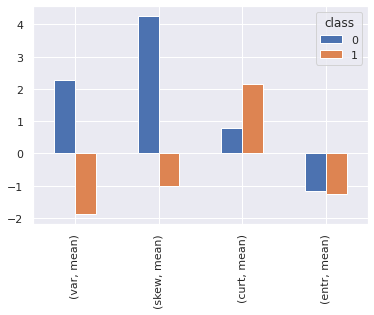

In [103]:
classes.loc[[('var','mean'),('skew','mean'),('curt','mean'),('entr','mean')]].plot.bar()

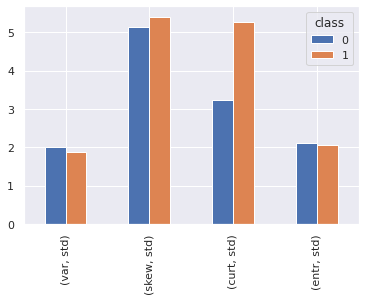

In [104]:
classes.loc[[('var','std'),('skew','std'),('curt','std'),('entr','std')]].plot.bar()

class
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

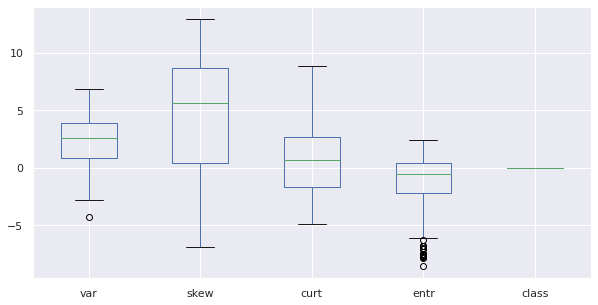

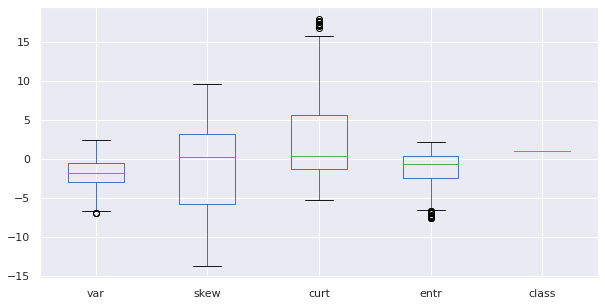

In [105]:
df.groupby('class').plot.box(figsize=(10,5))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbe6d751e90>,
      dtype=object)

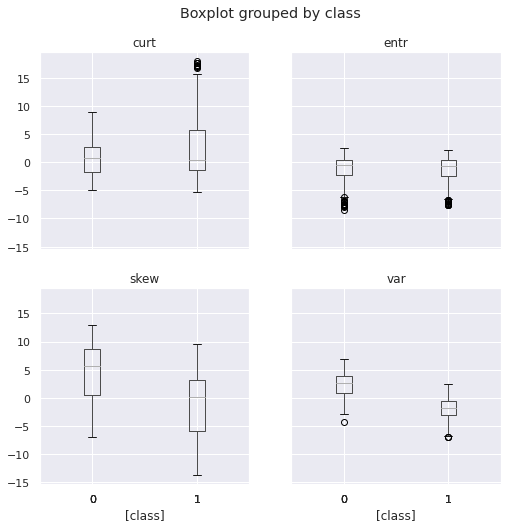

In [106]:
df.boxplot(by='class', figsize=(8,8))

In [107]:
df1 = df.loc[df['class'] == 1]
df2 = df.loc[df['class'] == 0]

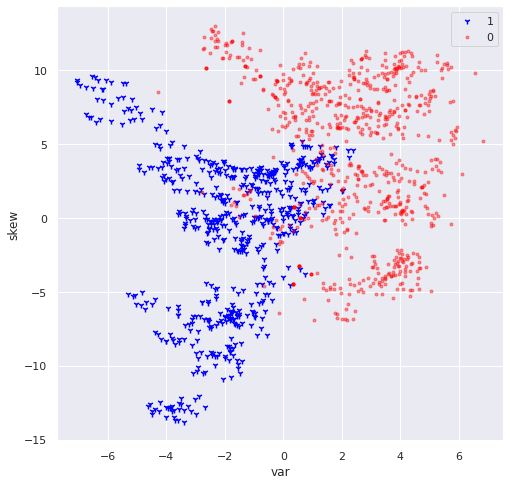

In [108]:
plt.figure(figsize=(8,8))
ax1 = plt.subplot(111)
ax1.scatter(df1['var'],df1['skew'],c='#0000ff',marker='1')
ax1.scatter(df2['var'],df2['skew'],c='#ff0000',marker='.',alpha=0.4)
ax1.set_xlabel('var')
ax1.set_ylabel('skew')
ax1.legend([1,0])

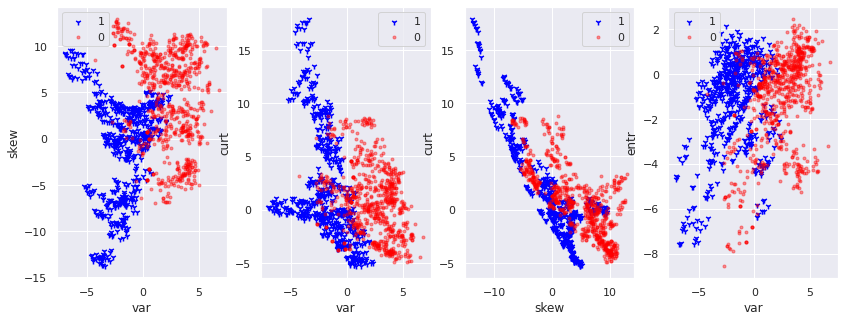

In [109]:
plt.figure(figsize=(14,5))
ax1, ax2, ax3, ax4 = plt.subplot(141), plt.subplot(142), plt.subplot(143), plt.subplot(144)
ax1.scatter(df1['var'],df1['skew'],c='#0000ff',marker='1')
ax1.scatter(df2['var'],df2['skew'],c='#ff0000',marker='.',alpha=0.4)
ax1.set_xlabel('var')
ax1.set_ylabel('skew')
ax1.legend([1,0])
ax2.scatter(df1['var'],df1['curt'],c='#0000ff',marker='1')
ax2.scatter(df2['var'],df2['curt'],c='#ff0000',marker='.',alpha=0.4)
ax2.set_xlabel('var')
ax2.set_ylabel('curt')
ax2.legend([1,0])
ax3.scatter(df1['skew'],df1['curt'],c='#0000ff',marker='1')
ax3.scatter(df2['skew'],df2['curt'],c='#ff0000',marker='.',alpha=0.4)
ax3.set_xlabel('skew')
ax3.set_ylabel('curt')
ax3.legend([1,0])
ax4.scatter(df1['var'],df1['entr'],c='#0000ff',marker='1')
ax4.scatter(df2['var'],df2['entr'],c='#ff0000',marker='.',alpha=0.4)
ax4.set_xlabel('var')
ax4.set_ylabel('entr')
ax4.legend([1,0])

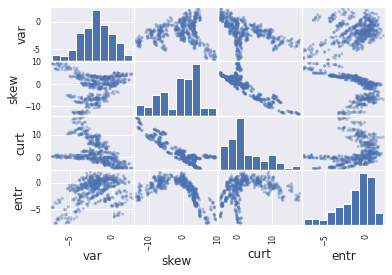

In [110]:
m1 = pd.plotting.scatter_matrix(df1[df.columns[0:-1]], alpha=0.4)

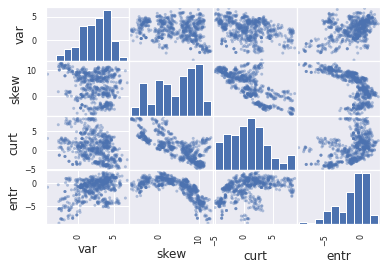

In [111]:
m2 = pd.plotting.scatter_matrix(df2[df.columns[0:-1]], alpha=0.4)

In [112]:
X = df[df.columns[0:4]]
y = df[df.columns[4:5]]

### Metrics

In [113]:
scoring = {
          'acc' : 'accuracy',
          'prec': 'precision',
          'rec': 'recall',
          'f1': 'f1',
           }

# MODELS

### Conjunto de validação

In [114]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=43)

### Conjuntos de estratificadas

In [115]:
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(X, y)

10

In [116]:
scores_clf = {}

## NAIVE BAYES

* i) **Classificador bayesiano gaussiano**: considere a seguinte regra de decisão: 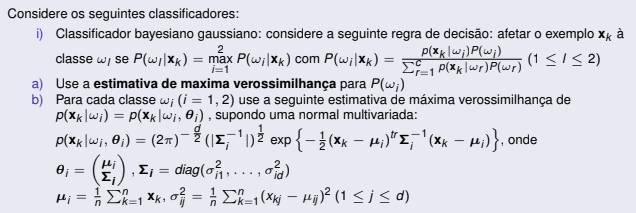

In [117]:
naives = GaussianNB()

In [118]:
naives.get_params()

{'priors': None, 'var_smoothing': 1e-09}

In [119]:
folds = skf

In [120]:
scores_nb = cross_validate(naives, X, np.ravel(y), scoring=scoring,
                        cv=folds, return_train_score=True)

pd.DataFrame(scores_nb).agg(['mean','std']).T

,mean,std
fit_time,0.002078,0.000681
score_time,0.004067,0.002767
test_acc,0.841077,0.040212
train_acc,0.841350,0.002765
test_prec,0.840844,0.033399
train_prec,0.842526,0.004713
test_rec,0.791803,0.075738
train_rec,0.791075,0.007825
test_f1,0.814474,0.052278
train_f1,0.815957,0.003725


## KNN

* ii) Treine um **classificador bayesiano baseados em k-vizinhos**. Normalize os dados e use a distância Euclidiana para definir a vizinhança. Use conjunto de validação para fixar o o número de vizinhos k.


*Normalization is the process of scaling individual samples to have unit norm. This process can be useful if you plan to use a quadratic form such as the dot-product or any other kernel to quantify the similarity of any pair of samples.*



**Normalization**

In [121]:
scaler = StandardScaler().fit(X)
X_norm = scaler.transform(X)
X_val_norm = scaler.transform(X_val)

*scikit-learn implements two different nearest neighbors classifiers: KNeighborsClassifier implements learning based on the  nearest neighbors of each query point, where  is an integer value specified by the user.*

*The basic nearest neighbors classification uses uniform weights: that is, the value assigned to a query point is computed from a simple majority vote of the nearest neighbors. Under some circumstances, it is better to weight the neighbors such that nearer neighbors contribute more to the fit. This can be accomplished through the weights keyword. The default value, weights = 'uniform', assigns uniform weights to each neighbor. weights = 'distance' assigns weights proportional to the inverse of the distance from the query point. Alternatively, a user-defined function of the distance can be supplied to compute the weights.*


**K search**

In [122]:
param_grid = [{'n_neighbors':range(1,11,2), 'weights':['uniform', 'distance'], 'metric':['euclidean','manhattan','chebyshev']}]

In [123]:
knn_val = KNeighborsClassifier()

In [124]:
clf = GridSearchCV(knn_val, param_grid, scoring=scoring, refit='f1')

In [125]:
clf.fit(X_val_norm,np.ravel(y_val))

GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'metric': ['euclidean', 'manhattan', 'chebyshev'],
                          'n_neighbors': range(1, 11, 2),
                          'weights': ['uniform', 'distance']}],
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring={'acc': 'accuracy', 'f1': 'f1', 'prec': 'precision',
                      'rec': 'recall'},
             verbose=0)

In [126]:
params_index = pd.MultiIndex.from_frame(pd.DataFrame(list(ParameterGrid(param_grid))))

In [127]:
pd.Series(clf.cv_results_['mean_test_f1'], index=params_index).reset_index()

,metric,n_neighbors,weights,0
0,euclidean,1,uniform,0.988386
1,euclidean,1,distance,0.988386
2,euclidean,3,uniform,0.988386
3,euclidean,3,distance,0.988386
4,euclidean,5,uniform,0.988386
5,euclidean,5,distance,0.988386
6,euclidean,7,uniform,0.984758
7,euclidean,7,distance,0.988386
8,euclidean,9,uniform,0.988386
9,euclidean,9,distance,0.988386


In [128]:
clf.best_params_

{'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}

In [129]:
clf.best_score_

0.9921568627450981

In [130]:
clf.best_estimator_.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'manhattan',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 1,
 'p': 2,
 'weights': 'uniform'}

#### Pipeline

In [131]:
kpipe = Pipeline([('scaler', MinMaxScaler()), ('KNN', clf.best_estimator_)])

In [132]:
scores_knn = cross_validate(kpipe, X, np.ravel(y), scoring=scoring,
                        cv=folds, return_train_score=True)

pd.DataFrame(scores_knn).agg(['mean','std']).T

,mean,std
fit_time,0.003884,0.002023
score_time,0.010021,0.005552
test_acc,0.998540,0.003078
train_acc,1.000000,0.000000
test_prec,0.996774,0.006801
train_prec,1.000000,0.000000
test_rec,1.000000,0.000000
train_rec,1.000000,0.000000
test_f1,0.998374,0.003428
train_f1,1.000000,0.000000


## PARZEN

* iii) Treine um **classificador bayesiano baseado em janela de Parzen**. Use a função de kernel multivariada produto com um mesmo h para todas as dimensões e a função de kernel Gaussiana unidimensional. Use conjunto de validação para fixar o parâmetro h. 

In [133]:
class ParzenClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE
    
    Parameters
    ----------
    bandwidth : float
        the kernel bandwidth within each class
    kernel : str
        the kernel name, passed to KernelDensity
    """
    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
        
    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                      kernel=self.kernel).fit(Xi)
                        for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                           for Xi in training_sets]
        return self
        
    def predict_proba(self, X):
        logprobs = np.array([model.score_samples(X)
                             for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)
        
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]

In [134]:
param_grid = [{'bandwidth':[0.01,0.1,0.125,0.15,0.25,0.5,1,2,3]}]

In [135]:
parzen = ParzenClassifier()

In [136]:
clf = GridSearchCV(parzen, param_grid, scoring=scoring, refit='f1')

In [137]:
clf.fit(X_val_norm,np.ravel(y_val))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


GridSearchCV(cv=None, error_score=nan,
             estimator=ParzenClassifier(bandwidth=1.0, kernel='gaussian'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'bandwidth': [0.01, 0.1, 0.125, 0.15, 0.25, 0.5, 1, 2,
                                        3]}],
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring={'acc': 'accuracy', 'f1': 'f1', 'prec': 'precision',
                      'rec': 'recall'},
             verbose=0)

In [138]:
list(zip(clf.cv_results_['params'],clf.cv_results_['mean_test_f1']))

[({'bandwidth': 0.01}, 0.8591404483208228),
 ({'bandwidth': 0.1}, 0.9883861236802414),
 ({'bandwidth': 0.125}, 0.9883861236802414),
 ({'bandwidth': 0.15}, 0.9883861236802414),
 ({'bandwidth': 0.25}, 0.9883861236802414),
 ({'bandwidth': 0.5}, 0.9883861236802414),
 ({'bandwidth': 1}, 0.9290599146368859),
 ({'bandwidth': 2}, 0.7735890946769406),
 ({'bandwidth': 3}, 0.4757251082251083)]

In [139]:
pd.Series(clf.cv_results_['mean_test_f1'], index=pd.DataFrame(clf.cv_results_['params'])['bandwidth']).reset_index()


,bandwidth,0
0,0.010,0.859140
1,0.100,0.988386
2,0.125,0.988386
3,0.150,0.988386
4,0.250,0.988386
5,0.500,0.988386
6,1.000,0.929060
7,2.000,0.773589
8,3.000,0.475725


In [140]:
h = clf.best_params_['bandwidth']

In [141]:
h

0.1

In [142]:
parzen = ParzenClassifier(bandwidth=h)

In [143]:
parzen.get_params()

{'bandwidth': 0.1, 'kernel': 'gaussian'}

In [144]:
scores_parz = cross_validate(parzen, X, np.ravel(y), scoring=scoring,
                        cv=folds, return_train_score=True)
pd.DataFrame(scores_parz).agg(['mean','std']).T

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


,mean,std
fit_time,0.003126,0.000810
score_time,0.009109,0.002432
test_acc,1.000000,0.000000
train_acc,1.000000,0.000000
test_prec,1.000000,0.000000
train_prec,1.000000,0.000000
test_rec,1.000000,0.000000
train_rec,1.000000,0.000000
test_f1,1.000000,0.000000
train_f1,1.000000,0.000000


## LOGISTIC REGRESSION 1

* iv) Treine um **classificador baseado em regressão logistica** com os 4 atributos numericos x1 , x2 , x3 , x4.

**Train/Evaluation**

In [145]:
logistic1 = LogisticRegression(penalty='none')

In [146]:
logistic1.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'none',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [147]:
scores_log = cross_validate(logistic1, X, np.ravel(y), scoring=scoring,
                        cv=folds, return_train_score=True)
pd.DataFrame(scores_log).agg(['mean','std']).T

,mean,std
fit_time,0.011124,0.003323
score_time,0.003557,0.001017
test_acc,0.988337,0.010989
train_acc,0.991092,0.001708
test_prec,0.985806,0.019914
train_prec,0.989810,0.002965
test_rec,0.988525,0.021926
train_rec,0.990164,0.001760
test_f1,0.986891,0.012370
train_f1,0.989985,0.001909


## LOGISTIC REGRESSION 2

* v) Treine um **classificador baseado em regressão logistica** com os 4 atributos numericos x1 , x2 , x3 , x4 originais e mais 4 atributos suplementares x<sub>5</sub> = x<sub>1</sub><sup>2</sup>  , x<sub>6</sub> = √x<sub>2</sub> , x<sub>7</sub> = log(x<sub>3</sub> ), x<sub>8</sub> = 1/x<sub>4</sub>. Use regularização. Use conjunto de validação para fixar o parâmetro de regularização.

**New features**

In [148]:
cols = X.columns

In [149]:
cols

Index(['var', 'skew', 'curt', 'entr'], dtype='object')

In [150]:
X_new = X.copy()

In [151]:
X_new['x5'] = X_new[cols[0]]**2
X_new['x6'] = abs(X_new[cols[1]])**(1/2)
X_new['x7'] = X_new[cols[2]].apply(lambda x: math.log(abs(x)))
X_new['x8'] = 1/(X_new[cols[3]])

**Regularization**

In [152]:
X_new_train, X_new_val, y_train, y_val = train_test_split(X_new, y, test_size=0.2, random_state=43)

In [153]:
param_grid = [{'penalty':['l1'], 'solver':['liblinear','saga'], 'C':[0.001,0.01,0.1,1,10,100,1000]}, {'penalty':['l2'], 'solver':['newton-cg','sag','lbfgs'], 'C':[0.001,0.01,0.1,1,10,100,1000]}, {'penalty':['elasticnet'], 'solver':['saga'], 'l1_ratio':[0.25,0.5,0.75], 'C':[0.001,0.01,0.1,1,10,100,1000]}]

In [154]:
param_grid

[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
  'penalty': ['l1'],
  'solver': ['liblinear', 'saga']},
 {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
  'penalty': ['l2'],
  'solver': ['newton-cg', 'sag', 'lbfgs']},
 {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
  'l1_ratio': [0.25, 0.5, 0.75],
  'penalty': ['elasticnet'],
  'solver': ['saga']}]

In [155]:
log_val = LogisticRegression()

In [156]:
clf = GridSearchCV(log_val, param_grid, scoring=scoring, refit='f1')

In [157]:
clf.fit(X_new_val,np.ravel(y_val))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined a

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10,...
                          'penalty': ['l1'], 'solver': ['liblinear', 'saga']},
                         {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'penalty': ['l2'],
                          'solver': ['newton-cg', 'sag', 'lbfgs']},
                         {'C

In [158]:
clf.best_params_

{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}

In [159]:
clf.best_score_

0.9919967987194879

In [160]:
params_index = pd.MultiIndex.from_frame(pd.DataFrame(list(ParameterGrid(param_grid))))

In [161]:
pd.Series(clf.cv_results_['mean_test_f1'], index=params_index).reset_index()

,C,penalty,solver,l1_ratio,0
0,0.001,l1,liblinear,NaN,0.000000
1,0.001,l1,saga,NaN,0.125000
2,0.010,l1,liblinear,NaN,0.852819
3,0.010,l1,saga,NaN,0.705315
4,0.100,l1,liblinear,NaN,0.975327
5,0.100,l1,saga,NaN,0.730282
6,1.000,l1,liblinear,NaN,0.987902
7,1.000,l1,saga,NaN,0.735724
8,10.000,l1,liblinear,NaN,0.991997
9,10.000,l1,saga,NaN,0.730282


In [162]:
list(zip(clf.cv_results_['params'],clf.cv_results_['mean_test_f1']))

[({'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}, 0.0),
 ({'C': 0.001, 'penalty': 'l1', 'solver': 'saga'}, 0.125),
 ({'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}, 0.8528187202080023),
 ({'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}, 0.7053154483513919),
 ({'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}, 0.975326513584157),
 ({'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}, 0.7302815675035574),
 ({'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}, 0.987901543596162),
 ({'C': 1, 'penalty': 'l1', 'solver': 'saga'}, 0.7357237443743058),
 ({'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}, 0.9919967987194879),
 ({'C': 10, 'penalty': 'l1', 'solver': 'saga'}, 0.7302815675035574),
 ({'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}, 0.9919967987194879),
 ({'C': 100, 'penalty': 'l1', 'solver': 'saga'}, 0.7357237443743058),
 ({'C': 1000, 'penalty': 'l1', 'solver': 'liblinear'}, 0.9919967987194879),
 ({'C': 1000, 'penalty': 'l1', 'solver': 'saga'}, 0.7357237443743058),
 ({'C': 0.001

Train/Evaluation

In [163]:
X

,var,skew,curt,entr
0,3.62160,8.66610,-2.8073,-0.44699
1,4.54590,8.16740,-2.4586,-1.46210
2,3.86600,-2.63830,1.9242,0.10645
3,3.45660,9.52280,-4.0112,-3.59440
4,0.32924,-4.45520,4.5718,-0.98880
...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949
1368,-1.38870,-4.87730,6.4774,0.34179
1369,-3.75030,-13.45860,17.5932,-2.77710
1370,-3.56370,-8.38270,12.3930,-1.28230


In [164]:
clf.best_estimator_.get_params()

{'C': 10,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

#### Pipeline

In [165]:
copyTransformer = FunctionTransformer(lambda x : x*1, validate=True,)
absTransformer = FunctionTransformer(np.abs, validate=True,)
squareTransformer = FunctionTransformer(np.square, validate=True,)
rootTransformer = FunctionTransformer(np.sqrt, validate=True)
logTransformer = FunctionTransformer(np.log, validate=True)
invTransformer = FunctionTransformer(np.reciprocal, validate=True)

In [166]:
coltransf = ColumnTransformer([
('varcopy', copyTransformer,['var']),
('skewcopy', copyTransformer,['skew']),
('curtcopy', copyTransformer,['curt']),
('entrcopy', copyTransformer,['entr']),
('var2', squareTransformer,['var']),
('skew2', Pipeline([
  ('abs', absTransformer),
  ('root', rootTransformer)
]) ,['skew']),
('curt2', Pipeline([
  ('abs', absTransformer),
  ('log', logTransformer)
]),['curt']),
('entr2', invTransformer,['entr'])
  ])

In [167]:
coltransf.fit_transform(X)[0:2]

array([[ 3.6216    ,  8.6661    , -2.8073    , -0.44699   , 13.11598656,
         2.94382404,  1.03222317, -2.23718651],
       [ 4.5459    ,  8.1674    , -2.4586    , -1.4621    , 20.66520681,
         2.85786634,  0.89959208, -0.68394775]])

In [168]:
lpipe = Pipeline([('coltransformer',coltransf),('logistic2', clf.best_estimator_)]) 

In [169]:
scores_log2 = cross_validate(lpipe, X, np.ravel(y), scoring=scoring,
                        cv=folds, return_train_score=True)
pd.DataFrame(scores_log2).agg(['mean','std']).T

,mean,std
fit_time,0.108017,0.008431
score_time,0.013363,0.002752
test_acc,0.997810,0.003526
train_acc,1.000000,0.000000
test_prec,0.996774,0.006801
train_prec,1.000000,0.000000
test_rec,0.998361,0.005184
train_rec,1.000000,0.000000
test_f1,0.997548,0.003949
train_f1,1.000000,0.000000


## ENSEMBLE



* vi) Treine um **classificador usando a regra do voto majoritario** usando os classificadores i) a v).

In [170]:
base_models = [['NB',naives],['KNN',kpipe],['Parzen',parzen],['Log1',logistic1],['Log2',lpipe]]

In [171]:
eclf = VotingClassifier(estimators=base_models, voting='hard')

In [172]:
scores_eclf = cross_validate(eclf, X_train, np.ravel(y_train), scoring=scoring,
                      cv=folds, return_train_score=True)
pd.DataFrame(scores_eclf).agg(['mean','std']).T

,mean,std
fit_time,0.096663,0.005422
score_time,0.023922,0.000790
test_acc,1.000000,0.000000
train_acc,1.000000,0.000000
test_prec,1.000000,0.000000
train_prec,1.000000,0.000000
test_rec,1.000000,0.000000
train_rec,1.000000,0.000000
test_f1,1.000000,0.000000
train_f1,1.000000,0.000000


# FRIEDMAN TEST

In [173]:
scores_test = {}
scores_test['nb'] = scores_nb
scores_test['knn'] = scores_knn
scores_test['parz'] = scores_parz
scores_test['log'] = scores_log
scores_test['log2'] = scores_log2
scores_test['eclf'] = scores_eclf

In [174]:
df_score = pd.DataFrame(scores_test).applymap(lambda x: x.mean()).drop(['fit_time','score_time'])
df_score_std = pd.DataFrame(scores_test).applymap(lambda x: x.std()).drop(['fit_time','score_time'])
df_score_ic = pd.DataFrame(scores_test).applymap(lambda x: "{:.0%} - {:.0%}".format(x.mean() - 1.96 * x.std(),x.mean()+1.96 * x.std())).drop(['fit_time','score_time'])

In [175]:
chart_index = ['train_acc','test_acc', 'train_prec', 'test_prec', 'train_rec','test_rec',  'train_f1' ,'test_f1']

In [176]:
df_score.reindex(['train_acc','test_acc', 'train_prec', 'test_prec', 'train_rec','test_rec',  'train_f1' ,'test_f1'])

,nb,knn,parz,log,log2,eclf
train_acc,0.841350,1.000000,1.0,0.991092,1.000000,1.0
test_acc,0.841077,0.998540,1.0,0.988337,0.997810,1.0
train_prec,0.842526,1.000000,1.0,0.989810,1.000000,1.0
test_prec,0.840844,0.996774,1.0,0.985806,0.996774,1.0
train_rec,0.791075,1.000000,1.0,0.990164,1.000000,1.0
test_rec,0.791803,1.000000,1.0,0.988525,0.998361,1.0
train_f1,0.815957,1.000000,1.0,0.989985,1.000000,1.0
test_f1,0.814474,0.998374,1.0,0.986891,0.997548,1.0


In [177]:
#df_score.reindex([ 'train_acc','test_acc', 'train_prec', 'test_prec', 'train_rec','test_rec',  'train_f1' ,'test_f1']).T.plot.bar(figsize=(18,6), fontsize=20)
#ax.legend(loc='best')

In [178]:
df_score.T[['train_acc','test_acc']]

,train_acc,test_acc
nb,0.841350,0.841077
knn,1.000000,0.998540
parz,1.000000,1.000000
log,0.991092,0.988337
log2,1.000000,0.997810
eclf,1.000000,1.000000


Text(0.5, 1.0, 'F1')

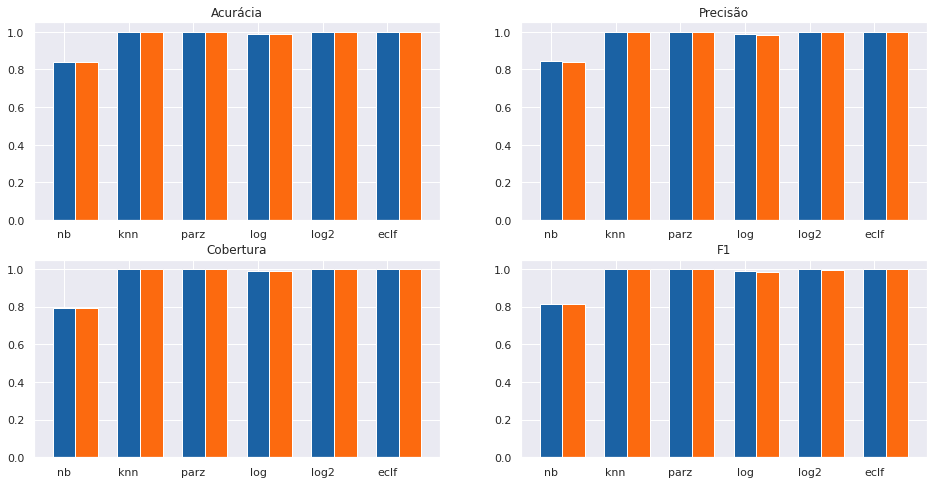

In [179]:
plt.figure(figsize=(16,8))
ax1, ax2, ax3, ax4 = plt.subplot(221), plt.subplot(222), plt.subplot(223), plt.subplot(224)
ax1.bar(np.arange(len(df_score.columns)), df_score.T['train_acc'], width=0.35, color="#1B62A4")
ax1.bar(np.arange(len(df_score.columns))+0.35,  df_score.T['test_acc'], width=0.35, color="#FC6A0F")
ax1.set_xticks(np.arange(len(df_score.columns)))
ax1.set_xticklabels(df_score.columns)
ax1.set_title('Acurácia')

ax2.bar(np.arange(len(df_score.columns)), df_score.T['train_prec'], width=0.35, color="#1B62A4", label='train_prec')
ax2.bar(np.arange(len(df_score.columns))+0.35,  df_score.T['test_prec'], width=0.35, color="#FC6A0F", label='test_prec')
ax2.set_xticks(np.arange(len(df_score.columns)))
ax2.set_xticklabels(df_score.columns)
ax2.set_title('Precisão')

ax3.bar(np.arange(len(df_score.columns)), df_score.T['train_rec'], width=0.35, color="#1B62A4", label='train_rec')
ax3.bar(np.arange(len(df_score.columns))+0.35,  df_score.T['test_rec'], width=0.35, color="#FC6A0F", label='test_rec')
ax3.set_xticks(np.arange(len(df_score.columns)))
ax3.set_xticklabels(df_score.columns)
ax3.set_title('Cobertura')

ax4.bar(np.arange(len(df_score.columns)), df_score.T['train_f1'], width=0.35, color="#1B62A4", label='train_f1')
ax4.bar(np.arange(len(df_score.columns))+0.35,  df_score.T['test_f1'], width=0.35, color="#FC6A0F", label='test_f1')
ax4.set_xticks(np.arange(len(df_score.columns)))
ax4.set_xticklabels(df_score.columns)
ax4.set_title('F1')

#df_score.T[['train_acc','test_acc']].plot.bar()
#ax4.legend(['train_acc','test_acc'])


Text(0.5, 1.0, 'F1')

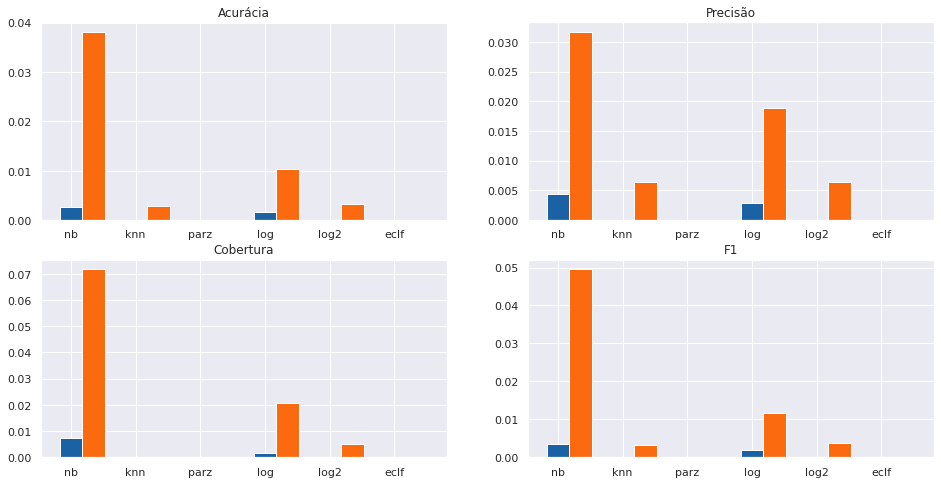

In [180]:
plt.figure(figsize=(16,8))
ax1, ax2, ax3, ax4 = plt.subplot(221), plt.subplot(222), plt.subplot(223), plt.subplot(224)
ax1.bar(np.arange(len(df_score.columns)), df_score_std.T['train_acc'], width=0.35, color="#1B62A4")
ax1.bar(np.arange(len(df_score.columns))+0.35,  df_score_std.T['test_acc'], width=0.35, color="#FC6A0F")
ax1.set_xticks(np.arange(len(df_score.columns)))
ax1.set_xticklabels(df_score.columns)
ax1.set_title('Acurácia')

ax2.bar(np.arange(len(df_score.columns)), df_score_std.T['train_prec'], width=0.35, color="#1B62A4", label='train_prec')
ax2.bar(np.arange(len(df_score.columns))+0.35,  df_score_std.T['test_prec'], width=0.35, color="#FC6A0F", label='test_prec')
ax2.set_xticks(np.arange(len(df_score.columns)))
ax2.set_xticklabels(df_score.columns)
ax2.set_title('Precisão')

ax3.bar(np.arange(len(df_score.columns)), df_score_std.T['train_rec'], width=0.35, color="#1B62A4", label='train_rec')
ax3.bar(np.arange(len(df_score.columns))+0.35,  df_score_std.T['test_rec'], width=0.35, color="#FC6A0F", label='test_rec')
ax3.set_xticks(np.arange(len(df_score.columns)))
ax3.set_xticklabels(df_score.columns)
ax3.set_title('Cobertura')

ax4.bar(np.arange(len(df_score.columns)), df_score_std.T['train_f1'], width=0.35, color="#1B62A4", label='train_f1')
ax4.bar(np.arange(len(df_score.columns))+0.35,  df_score_std.T['test_f1'], width=0.35, color="#FC6A0F", label='test_f1')
ax4.set_xticks(np.arange(len(df_score.columns)))
ax4.set_xticklabels(df_score.columns)
ax4.set_title('F1')


In [181]:
df_score_ic

,nb,knn,parz,log,log2,eclf
test_acc,77% - 92%,99% - 100%,100% - 100%,97% - 101%,99% - 100%,100% - 100%
train_acc,84% - 85%,100% - 100%,100% - 100%,99% - 99%,100% - 100%,100% - 100%
test_prec,78% - 90%,98% - 101%,100% - 100%,95% - 102%,98% - 101%,100% - 100%
train_prec,83% - 85%,100% - 100%,100% - 100%,98% - 100%,100% - 100%,100% - 100%
test_rec,65% - 93%,100% - 100%,100% - 100%,95% - 103%,99% - 101%,100% - 100%
train_rec,78% - 81%,100% - 100%,100% - 100%,99% - 99%,100% - 100%,100% - 100%
test_f1,72% - 91%,99% - 100%,100% - 100%,96% - 101%,99% - 100%,100% - 100%
train_f1,81% - 82%,100% - 100%,100% - 100%,99% - 99%,100% - 100%,100% - 100%


In [182]:
result_friedman = {}
print('Friedman Test')
for k in scoring:

  metric = 'test_'+k


  stat, p = friedmanchisquare(scores_test['nb'][metric],
                              scores_test['knn'][metric],
                              scores_test['parz'][metric],
                              scores_test['log'][metric],
                              scores_test['log2'][metric],
                              scores_test['eclf'][metric]
                              )
  print(metric)
  print('stat: ')
  print(stat)
  print('p: ')
  print(p)
  print('****')

  result_friedman[metric] = {'stat': stat, 'p': p}

Friedman Test
test_acc
stat: 
40.34
p: 
1.2752147264511486e-07
****
test_prec
stat: 
39.33035714285715
p: 
2.0376026839523167e-07
****
test_rec
stat: 
42.90322580645159
p: 
3.865774417265495e-08
****
test_f1
stat: 
40.34
p: 
1.2752147264511486e-07
****


In [183]:
pd.DataFrame(result_friedman).T

,stat,p
test_acc,40.340000,1.275215e-07
test_prec,39.330357,2.037603e-07
test_rec,42.903226,3.865774e-08
test_f1,40.340000,1.275215e-07


In [184]:
result_nemeneyi = {}
print('Nemenyi')
for k in scoring:

  metric = 'test_'+k

  df = pd.DataFrame({
      'nb': scores_test['nb'][metric],
      'knn': scores_test['knn'][metric],
      'parz': scores_test['parz'][metric],
      'log': scores_test['log'][metric],
      'log2': scores_test['log2'][metric],
      'eclf': scores_test['eclf'][metric]
  })

  p = sp.posthoc_nemenyi_friedman(df)
  print(metric)
  print('p: ')
  print(p)
  print('****')
  result_nemeneyi[metric] = p
  

Nemenyi
test_acc
p: 
            nb       knn      parz       log      log2      eclf
nb    1.000000  0.001822  0.001000  0.359078  0.005644  0.001000
knn   0.001822  1.000000  0.900000  0.433820  0.900000  0.900000
parz  0.001000  0.900000  1.000000  0.181482  0.900000  0.900000
log   0.359078  0.433820  0.181482  1.000000  0.611552  0.181482
log2  0.005644  0.900000  0.900000  0.611552  1.000000  0.900000
eclf  0.001000  0.900000  0.900000  0.181482  0.900000  1.000000
****
test_prec
p: 
            nb       knn      parz       log      log2      eclf
nb    1.000000  0.003632  0.001000  0.139024  0.004535  0.001000
knn   0.003632  1.000000  0.900000  0.818648  0.900000  0.900000
parz  0.001000  0.900000  1.000000  0.542518  0.900000  0.900000
log   0.139024  0.818648  0.542518  1.000000  0.853165  0.542518
log2  0.004535  0.900000  0.900000  0.853165  1.000000  0.900000
eclf  0.001000  0.900000  0.900000  0.542518  0.900000  1.000000
****
test_rec
p: 
            nb       knn      pa

In [185]:
pd.DataFrame(result_nemeneyi['test_acc'])

,nb,knn,parz,log,log2,eclf
nb,1.000000,0.001822,0.001000,0.359078,0.005644,0.001000
knn,0.001822,1.000000,0.900000,0.433820,0.900000,0.900000
parz,0.001000,0.900000,1.000000,0.181482,0.900000,0.900000
log,0.359078,0.433820,0.181482,1.000000,0.611552,0.181482
log2,0.005644,0.900000,0.900000,0.611552,1.000000,0.900000
eclf,0.001000,0.900000,0.900000,0.181482,0.900000,1.000000


In [186]:
pd.DataFrame(result_nemeneyi['test_prec'])

,nb,knn,parz,log,log2,eclf
nb,1.000000,0.003632,0.001000,0.139024,0.004535,0.001000
knn,0.003632,1.000000,0.900000,0.818648,0.900000,0.900000
parz,0.001000,0.900000,1.000000,0.542518,0.900000,0.900000
log,0.139024,0.818648,0.542518,1.000000,0.853165,0.542518
log2,0.004535,0.900000,0.900000,0.853165,1.000000,0.900000
eclf,0.001000,0.900000,0.900000,0.542518,0.900000,1.000000


In [187]:
pd.DataFrame(result_nemeneyi['test_rec'])

,nb,knn,parz,log,log2,eclf
nb,1.000000,0.001822,0.001822,0.047415,0.004535,0.001822
knn,0.001822,1.000000,0.900000,0.900000,0.900000,0.900000
parz,0.001822,0.900000,1.000000,0.900000,0.900000,0.900000
log,0.047415,0.900000,0.900000,1.000000,0.900000,0.900000
log2,0.004535,0.900000,0.900000,0.900000,1.000000,0.900000
eclf,0.001822,0.900000,0.900000,0.900000,0.900000,1.000000


In [188]:
pd.DataFrame(result_nemeneyi['test_f1'])

,nb,knn,parz,log,log2,eclf
nb,1.000000,0.001822,0.001000,0.359078,0.005644,0.001000
knn,0.001822,1.000000,0.900000,0.433820,0.900000,0.900000
parz,0.001000,0.900000,1.000000,0.181482,0.900000,0.900000
log,0.359078,0.433820,0.181482,1.000000,0.611552,0.181482
log2,0.005644,0.900000,0.900000,0.611552,1.000000,0.900000
eclf,0.001000,0.900000,0.900000,0.181482,0.900000,1.000000
